In [1]:
%reload_ext autoreload
%autoreload 2

The following example was taken from el original paper. The main idea here is reproducing the same results (or similar at least)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

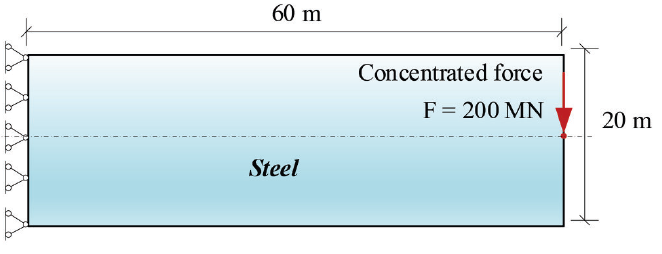

### General Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In [4]:
from mesh_utils import UniformQuadMesh2D

lx = 60                 # Dimension along x-coord (in meters)
ly = 20                 # Dimension along y-coord (in meters)
nx = 30                 # Number of elements along x-coord
ny = 10                 # Number of elements along y-coord
element_type = 'Q4'     # Type of elements

cantilever_mesh = UniformQuadMesh2D(lx, ly, nx, ny, element_type=element_type)
cantilever_mesh.compute()

print(f'\nNumber of nodes: {cantilever_mesh.nnod}')
print(f'Number of elements: {cantilever_mesh.nelem}')

cantilever_mesh.add_node_group('load', [int(((0.5*ny)+1)*(nx+1))])


Number of nodes: 341
Number of elements: 300


### Dirichlet boundary conditions

In [5]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [6]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(EMOD = 200*1e3, nu = 0.30)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [7]:
from feinn_solver import NodalLoad
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'right': EdgeLoad(side = 4, ftangential = 0, fnormal = -200/ly, reference = "global"),
                        }

cantilever_load = {
                    'load': NodalLoad(fx = 0.0, fy = -200),
                    }

### Model

In [8]:
from feinn_solver import NFEA

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      # edge_loads = cantilever_edge_loads,
                      nodal_loads = cantilever_load,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 300 elements have assigned material
[nodal_load] Applied 1 nodal load groups
[BC] Processed 2 Dirichlet condition(s) → 22 total constraint(s)
[BC] Applied Dirichlet BCs → 22 fixed DOFs


In [9]:
cantilever_fem.formulation = 'infinitesimal'
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 3.88e-13  Energetic error: -1.48e-12
Iter   2 | du error: 5.72e-14  Res error: 1.30e-13  Energetic error: 9.50e-28
Converged in 2 iterations


In [10]:
cantilever_fem.udisp

tensor([ 0.0000e+00,  0.0000e+00, -1.9503e-03, -1.1004e-03, -3.6328e-03,
        -2.0277e-03, -5.2383e-03, -3.2026e-03, -6.7972e-03, -4.6521e-03,
        -8.3067e-03, -6.3965e-03, -9.7630e-03, -8.4336e-03, -1.1163e-02,
        -1.0756e-02, -1.2505e-02, -1.3352e-02, -1.3789e-02, -1.6212e-02,
        -1.5013e-02, -1.9322e-02, -1.6177e-02, -2.2671e-02, -1.7282e-02,
        -2.6247e-02, -1.8327e-02, -3.0039e-02, -1.9312e-02, -3.4033e-02,
        -2.0238e-02, -3.8218e-02, -2.1103e-02, -4.2583e-02, -2.1909e-02,
        -4.7115e-02, -2.2656e-02, -5.1802e-02, -2.3343e-02, -5.6632e-02,
        -2.3970e-02, -6.1594e-02, -2.4537e-02, -6.6675e-02, -2.5044e-02,
        -7.1865e-02, -2.5491e-02, -7.7151e-02, -2.5875e-02, -8.2521e-02,
        -2.6193e-02, -8.7963e-02, -2.6439e-02, -9.3460e-02, -2.6606e-02,
        -9.8987e-02, -2.6692e-02, -1.0451e-01, -2.6715e-02, -1.0998e-01,
        -2.6714e-02, -1.1540e-01,  0.0000e+00,  0.0000e+00, -1.2762e-03,
        -6.2866e-04, -2.6664e-03, -1.5915e-03, -3.9

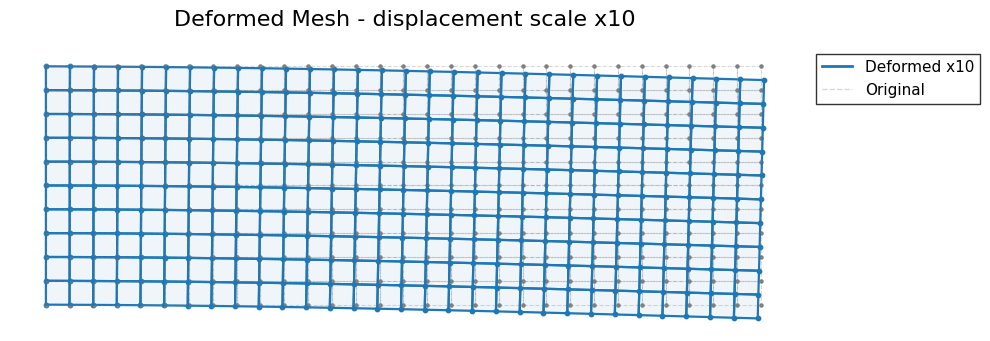

In [11]:
cantilever_fem.plot_deformed_mesh(scale=10)

In [12]:
from feinn_solver import FEINN
from nn_models import mFCNet

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    edge_loads=cantilever_edge_loads,
    nnet = mFCNet(),
    nnet_init = 'xavier',
    verbose=False,
    bc_weight=1,
    )


In [13]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 5000
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-3

In [14]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs=cfg.epochs, 
                   optimizer=optimizer, 
                   scheduler=scheduler, 
                   verbose=True)



Epoch 1/5000
Total Loss: 1.654e+00
  Domain: 4.613e-08
  BC:     1.654e+00
  Domain grad norm: 3.32e-13
  BC grad norm:     9.23e+01


KeyboardInterrupt: 

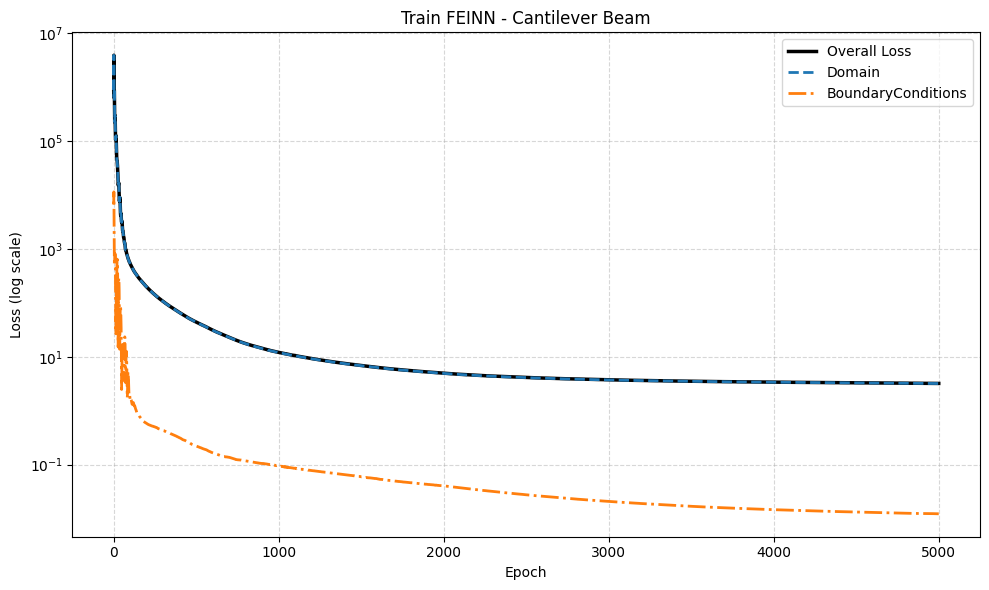

In [ ]:

feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [ ]:
feinn_solver.udisp

tensor([ 2.4290e-04,  1.9994e-05,  2.5422e-04,  7.0588e-05,  2.7283e-04,
         1.2420e-04,  2.9440e-04,  1.9345e-04,  3.1461e-04,  2.6026e-04,
         3.3020e-04,  3.0513e-04,  3.4765e-04,  3.5818e-04,  3.6509e-04,
         4.1122e-04,  3.8254e-04,  4.6426e-04,  4.0450e-04,  5.4333e-04,
         4.2098e-04,  6.2551e-04,  4.3845e-04,  6.9619e-04,  4.5379e-04,
         7.5683e-04,  4.6790e-04,  7.9709e-04,  4.8214e-04,  8.3846e-04,
         4.9370e-04,  9.0568e-04,  5.0525e-04,  9.7289e-04,  5.1681e-04,
         1.0401e-03,  5.2868e-04,  1.1115e-03,  5.3957e-04,  1.1554e-03,
         5.5091e-04,  1.1938e-03,  5.5849e-04,  1.2286e-03,  5.6639e-04,
         1.2601e-03,  5.7581e-04,  1.2764e-03,  5.8524e-04,  1.2927e-03,
         5.9466e-04,  1.3089e-03,  6.0408e-04,  1.3252e-03,  6.2329e-04,
         1.3549e-03,  6.3451e-04,  1.3547e-03,  6.4572e-04,  1.3544e-03,
         6.5694e-04,  1.3542e-03,  1.8604e-04,  3.0215e-06,  2.0240e-04,
         6.3869e-05,  2.1902e-04,  1.2561e-04,  2.3

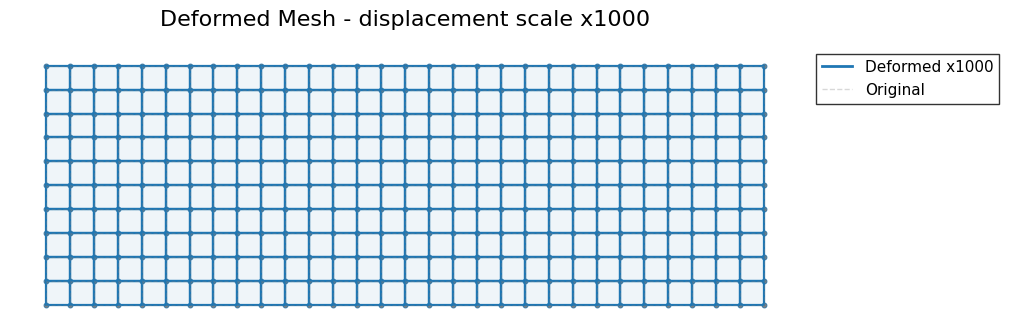

In [ ]:
feinn_solver.plot_deformed_mesh(scale=1000)